In [1]:
using Revise

# Put the path to xfac here
#ENV["PYTHONPATH"] = "/Users/Ritter.Marc/src/xfac/python/"

using QuanticsTCI
using TensorCrossInterpolation
using ITensors
using PyPlot

Did not find xfac. QTT functions will not be available.PyError (PyImport_ImportModule

The Python package xfacpy could not be imported by pyimport. Usually this means
that you did not install xfacpy in the Python version being used by PyCall.

PyCall is currently configured to use the Python version at:

/Users/Ritter.Marc/.pyenv/versions/3.8.15/bin/python

and you should use whatever mechanism you usually use (apt-get, pip, conda,
etcetera) to install the Python package containing the xfacpy module.

One alternative is to re-configure PyCall to use a different Python
version on your system: set ENV["PYTHON"] to the path/name of the python
executable you want to use, run Pkg.build("PyCall"), and re-launch Julia.

Another alternative is to configure PyCall to use a Julia-specific Python
distribution via the Conda.jl package (which installs a private Anaconda
Python distribution), which has the advantage that packages can be installed
and kept up-to-date via Julia.  As explained in the P

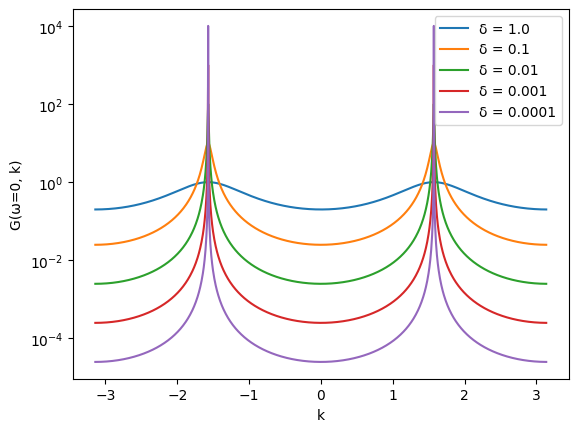

PyObject <matplotlib.legend.Legend object at 0x16ecd7820>

In [2]:
n = 24
npoints = 2^n
kpoints = range(-pi, pi; length=npoints)
plotstep = div(npoints, 1024)

e_k = 2.0 .* cos.(kpoints)
D = 2.0

omegapoints = range(-1.5D, 1.5D; length=301)
deltas = 10.0.^(.- (0:4))

function G(omega, delta)
    return 1 ./ (omega + 1im * delta .- e_k)
end

for δ in deltas
    semilogy(kpoints[1:plotstep:end], -imag.(G(0, δ)[1:plotstep:end]), label="δ = $δ")
end

xlabel("k")
ylabel("G(ω=0, k)")
legend()

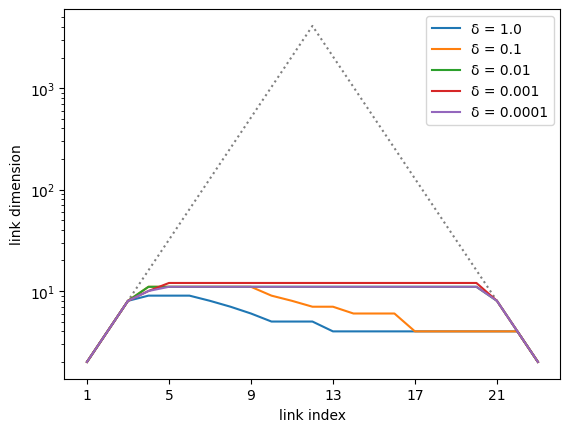

PyObject <matplotlib.legend.Legend object at 0x16f7ca880>

In [3]:
struct qttres
    mps::MPS
    ranks::Vector{Int}
    errors::Vector{Float64}
end

function Green_mps(omega, delta)
    f(q) = imag(1.0 / (omega + 1im * delta - e_k[quantics_to_index(q)[1]]))
    firstpivot = TensorCrossInterpolation.optfirstpivot(f, fill(2, n))
    # G_qtt, ranks, errors = qtt(
    #     q -> imag(1.0 / (omega + 1im * delta - e_k[quantics_to_index(q .+ 1)[1]])),
    #     2,
    #     firstpivot;
    #     cutoff=1e-8, maxiter=200
    # )

    G_tci, ranks, errors = crossinterpolate(
        f,
        fill(2, n),
        firstpivot;
        tolerance=1e-8, maxiter=200
    )
    G_qtt = tensortrain(G_tci)

    indices = [Index(2, "site") for i in 1:n]
    return qttres(qtt_to_mps(G_qtt, indices), ranks, errors)
end

G_mpss = [Green_mps(0, δ) for δ in deltas]

semilogy(
    1:n-1,
    [min(2^i, 2^(n - i)) for i in 1:(n-1)];
    color="gray", linestyle="dotted")
for (δ, G_mps) in zip(deltas, G_mpss)
    plot(1:n-1, ITensors.linkdims(G_mps.mps), label="δ = $δ")
end

xticks(1:4:n)
xlabel("link index")
ylabel("link dimension")
legend()

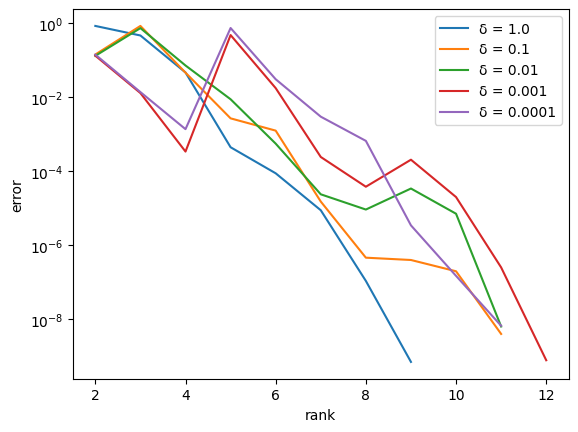

PyObject <matplotlib.legend.Legend object at 0x2b5282340>

In [4]:
for (δ, res) in zip(deltas, G_mpss)
    semilogy(res.ranks, res.errors, label="δ = $δ")
end
xlabel("rank")
ylabel("error")
legend()

step = div(npoints, 1024) = 16384


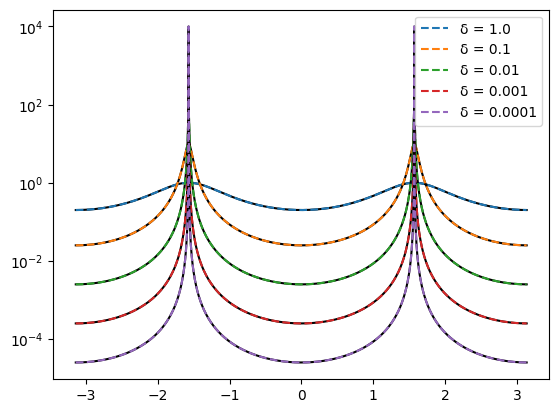

PyObject <matplotlib.legend.Legend object at 0x2b549d550>

In [5]:
@show step = div(npoints, 1024)

for (δ, res) in zip(deltas, G_mpss)
    Gpoints = imag.(G(0, δ))[1:step:end]
    semilogy(kpoints[1:step:end], -Gpoints, "black")

    G_mps = res.mps
    mps_data = [
        evaluate_mps(G_mps, siteinds(G_mps), index_to_quantics(i, n))
        for i in 1:step:npoints]
    line = semilogy(kpoints[1:step:end], -mps_data, "--", label="δ = $δ")
    #semilogy(kpoints[1:step:end], abs.(mps_data - Gpoints), linestyle=":", color=line[1].get_color())
end
legend()

In [6]:
function sum_quantics_mps(mps)
    m = mps[1] * ITensor(1, siteind(mps, 1))
    for i in 2:n
        m *= mps[i] * ITensor(1, siteind(mps, i))
    end
    return scalar(m)
end

Greens = [
    Green_mps(omega, δ)
    for omega in omegapoints, δ in deltas
];

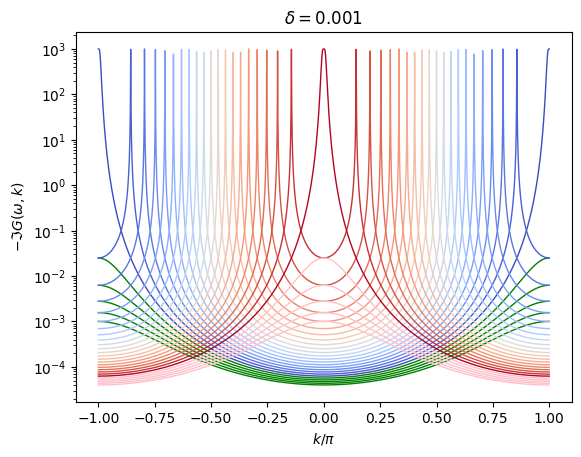

In [7]:
cmap = get_cmap("coolwarm")
function omegacolor(ω)
    if ω < -D
        return "green"
    elseif ω > D
        return "pink"
    else
        return cmap(0.5 + 0.5ω / D)
    end
end

plotindices = round.(Int, range(1, npoints, length=10000))

fig, axs = subplots(squeeze=false)
ax = axs[1, 1]

ax.set_xlabel("\$k/\\pi\$")
 ax.set_ylabel("\$-\\Im G(\\omega, k)\$")
ax.set_title("\$\\delta = 0.001\$")

for ω in omegapoints[1:10:301]
    ax.semilogy(
        kpoints[plotindices]/pi,
        -imag.(G(ω, 0.001))[plotindices],
        color=omegacolor(ω),
        linewidth=1)
end

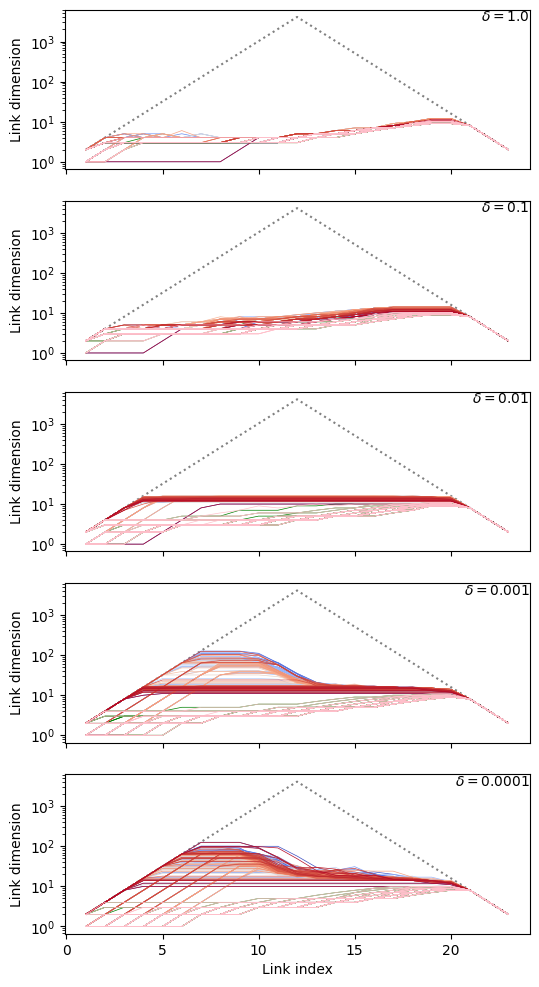

In [8]:
fig, axs = subplots(nrows=length(deltas), figsize=(6, 12), sharex=true)

axs[end].set_xlabel("Link index")

for (ax, Greencol, δ) in zip(axs, eachcol(Greens), deltas)
    ax.set_ylabel("Link dimension")

    ax.semilogy(
        1:n-1,
        [min(2^i, 2^(n - i)) for i in 1:(n-1)];
        color="gray", linestyle="dotted")
    
    ax.annotate(
        "\$\\delta = $δ\$",
        xy=(1, 1),
        xycoords="axes fraction",
        horizontalalignment="right",
        verticalalignment="top"
    )
    
    for (omega, Green) in zip(omegapoints, Greencol)
        ax.plot(
            1:n-1,
            reverse(ITensors.linkdims(Green.mps)),
            color=omegacolor(omega),
            linewidth=0.5
            )
    end
end


In [13]:
for (δ, Greencol) in zip(deltas, eachcol(Greens))
    loglog([δ], [maximum(maximum(ITensors.linkdims.([Green.mps for Green in Greencol])))], "o")
end

LoadError: UndefVarError: Greens not defined

In [14]:
spectralfunctions = [
    sum_quantics_mps(Green.mps) for Green in Greens]

G_analytic(z) = sign(2abs(z + sqrt(Complex(z^2 - 0.25))) - 1) / sqrt(Complex(z^2 - 0.25))

for (δ, A) in zip(deltas, eachcol(spectralfunctions))
    semilogy(omegapoints, -imag(G_analytic.((omegapoints .+ im * δ)/ (2D))), "black")
    semilogy(omegapoints, -4A/npoints, "--", label="δ = $δ")
end

xlabel("ω")
ylabel("A(ω) = -∫dk Im G(ω, k) / π")
legend()

LoadError: UndefVarError: Greens not defined

In [15]:
n = 20
npoints = 2^n
kpoints = range(-pi, pi; length=npoints)

e_k = 2.0 .* cos.(kpoints)
D = 2.0
omegapoints = range(-D, D; length=npoints)
delta = 1e-3

function G_q2d(q)
    (qw, qk) = deinterleave_dimensions(q .+ 1, 2)
    w = omegapoints[quantics_to_index(qw)[1]]
    e = e_k[quantics_to_index(qk)[1]]
    return imag(1.0 / (w + 1im * delta - e))
end

firstpivot = ones(Int, 2 * n)
G2_qtt, ranks, errors = qtt(
    G_q2d,
    2,
    firstpivot;
    cutoff=1e-5, maxiter=250
)
indices = [Index(2, "site") for i in 1:(2*n)]
@show G2_mps = qtt_to_mps(G2_qtt, indices)

semilogy(ranks, errors)

LoadError: InterruptException:

In [ ]:
semilogy([min(2^i, 2^(2 * n - i)) for i in 1:(2*n-1)];
    color="gray", linestyle="dotted")
plot(linkdims(G2_mps))

In [ ]:
G2_mps_summed = MPS(n)

for i in 1:n
    s = siteind(G2_mps, 2*i)
    G2_mps_summed[i] = G2_mps[2 * i - 1] * G2_mps[2 * i] * ITensor(1, s)
    #G2_mps_summed[i] = ITensor(1, s) * G2_mps[2 * i - 1] * G2_mps[2 * i]
end

stride = 2^(n - 8)

spectralfunction2 = [
    evaluate_mps(G2_mps_summed, siteinds(G2_mps_summed), index_to_quantics(i, n))
    for i in 1:stride:npoints
]

semilogy(omegapoints[1:stride:end], -spectralfunction2)

In [ ]:
16 * 32

In [ ]:
2 ^ 30